In [15]:
import glob
import cv2
from cv2 import drawContours
import os
import datetime
import pydot
os.environ['DISPLAY'] = ':1'
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import argparse
import imutils
from scipy import interpolate
import skimage
import skimage.morphology
import pwlf

import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from skimage import data_dir,io,transform,color

In [16]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [17]:
# Define a simple Unet, for further design customed neural network structure.

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(75, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(400, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(400, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(1200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(400, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(400, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(400, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(200, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(200, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(100, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[sm.metrics.iou_score])

    #model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
    
    model.summary()
    
    return model

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
#model = get_model()

In [18]:
# Date import and process

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("Semantic_Segmentation/training_data/images_aug"):
    img_path = glob.glob(os.path.join(directory_path, '*.png'))
    img_path.sort()
    for i in img_path:
        img = cv2.imread(i, cv2.IMREAD_COLOR)
        reflect_img = cv2.copyMakeBorder(img,8,8,8,8,cv2.BORDER_REFLECT)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)       
        train_images.append(reflect_img)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture label info as a list
train_labels = [] 
for directory_path in glob.glob("Semantic_Segmentation/training_data/labels_aug"):
    label_path = glob.glob(os.path.join(directory_path, '*.png'))
    label_path.sort()
    for j in label_path:
        label = cv2.imread(j, 0)
        reflect_label = cv2.copyMakeBorder(label,8,8,8,8,cv2.BORDER_REFLECT)       
        #label = cv2.cvtColor(label, cv2.COLOR_RGB2BGR)
        train_labels.append(reflect_label)
#Convert list to array for machine learning processing          
train_labels = np.array(train_labels)


#Use customary x_train and y_train variables
X = train_images
#X = np.expand_dims(X, axis=3) 
Y = train_labels
Y = np.expand_dims(Y, axis=3) #May not be necessary..

#Splite data into training set and validation set
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

y_train = tf.keras.utils.normalize(y_train)
y_val = tf.keras.utils.normalize(y_val)

IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]

# preprocess input
#x_train = preprocess_input(x_train)
#x_val = preprocess_input(x_val)

(8, 1216, 1216, 3)
(2, 1216, 1216, 3)
(8, 1216, 1216, 1)
(2, 1216, 1216, 1)


(-0.5, 1215.5, 1215.5, -0.5)

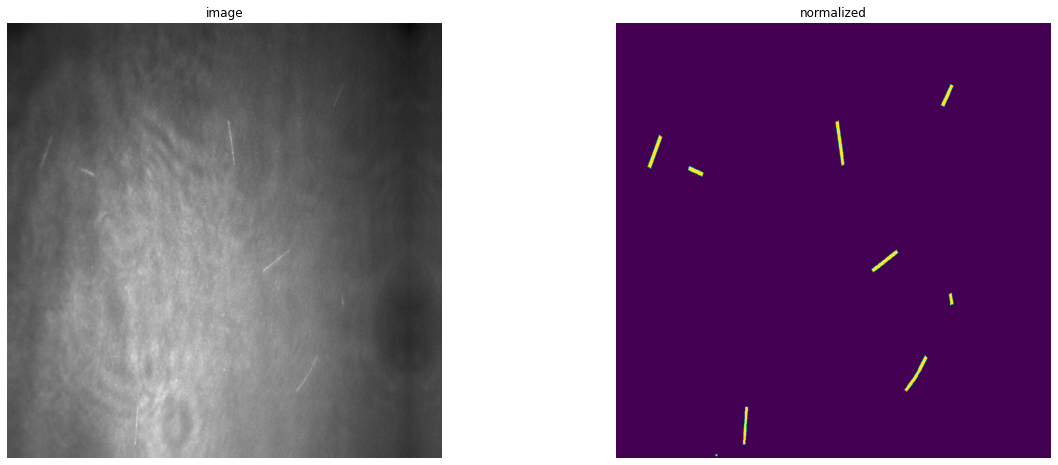

In [19]:
#Sanity check, view few mages
imgsize1 = x_train.shape
print(imgsize1)
imgsize2 = x_val.shape
print(imgsize2)
imgsize3 = y_train.shape
print(imgsize3)
imgsize4 = y_val.shape
print(imgsize4)

import random
image_number = random.randint(0, len(x_train))

ret, binary_map = cv2.threshold(y_train[image_number], 0, 255, cv2.THRESH_BINARY)

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax[0].imshow(x_train[image_number])
ax[0].set_title('image')
ax[0].axis('off')

#y_train_squeeze = y_train_nor[image_number]
#y_train_squeeze = y_train_squeeze[:,:,0]
ax[1].imshow(y_train[image_number])
ax[1].set_title('normalized')
ax[1].axis('off')

____________
stage3_unit4_conv1 (Conv2D)     (None, None, None, 2 589824      zero_padding2d_56[0][0]          
__________________________________________________________________________________________________
stage3_unit4_bn2 (BatchNormaliz (None, None, None, 2 1024        stage3_unit4_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit4_relu2 (Activation) (None, None, None, 2 0           stage3_unit4_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_57 (ZeroPadding2 (None, None, None, 2 0           stage3_unit4_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit4_conv2 (Conv2D)     (None, None, None, 2 589824      zero_padding2d_57[0][0]          
________________________________________________________________________________________________

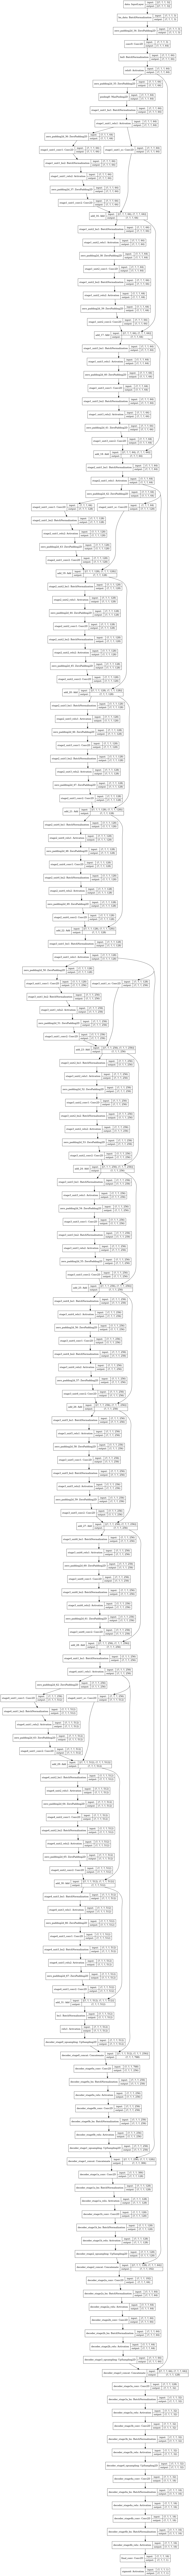

In [20]:
# Model von Segmentation_Models

# Encoder
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define optomizer
LR = 0.001
optim = keras.optimizers.Adam(LR)

# Model from the package semantic segmentation
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer = optim, loss = sm.losses.bce_jaccard_loss, metrics = [sm.metrics.iou_score])

print("The model architecture:\n")
print(model.summary())

output_folder = "Semantic_Segmentation/model_output"
log_dir = os.path.join(output_folder,'logs_{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

tf.keras.utils.plot_model(model,to_file=os.path.join(log_dir,'model.png'),show_shapes=True,show_layer_names=True)


In [21]:
# Training

#ModelCheckPoints
checkpointer = tf.keras.callbacks.ModelCheckpoint('MT_1216_Semantic_Segmentation.h5', verbose = 1, save_best_only = True)

callbacks = [#tf.keras.callbacks.EarlyStopping(patience = 4,monitor='val_iou_score'), 
             tf.keras.callbacks.TensorBoard(log_dir = './Semantic_Segmentation/logs')]
#Training

history = model.fit(x_train, y_train, 
                    batch_size = 2, 
                    #verbose = 1, 
                    epochs = 2, 
                    callbacks=callbacks,
                    validation_data=(x_val, y_val)
                    #shuffle=False
                    )

model.save('./Semantic_Segmentation/MT_1216_Semantic_Segmentation.h5')

Epoch 1/2
4/4 [==============================] - 4s 973ms/step - loss: 1.4586 - iou_score: 0.0047 - val_loss: 1.9296 - val_iou_score: 0.0049
Epoch 2/2
4/4 [==============================] - 3s 635ms/step - loss: 1.2902 - iou_score: 0.0051 - val_loss: 5.6049 - val_iou_score: 0.0043


In [22]:
# evaluate model
_, acc = model.evaluate(x_val, y_val, batch_size = 1)
print("Accuracy = ", (acc * 100.0), "%")

2/2 [==============================] - 0s 50ms/step - loss: 5.6049 - iou_score: 0.0043
Accuracy =  0.4308481700718403 %


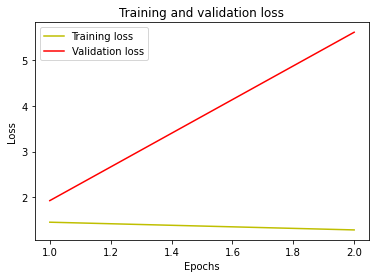

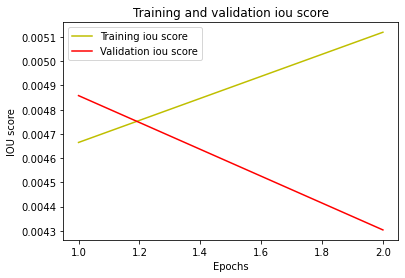

In [23]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.imsave('Semantic_Segmentation/loss_plot.png', cmap='gray')

#acc = history.history['acc']
acc = history.history['iou_score']
#val_acc = history.history['val_acc']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training iou score')
plt.plot(epochs, val_acc, 'r', label='Validation iou score')
plt.title('Training and validation iou score')
plt.xlabel('Epochs')
plt.ylabel('IOU score')
plt.legend()
plt.show()
#plt.imsave('Semantic_Segmentation/iou_score_plot.png', cmap='gray')

In [24]:
#Threshold adjustment for better result

#thre_model = keras.models.load_model("MT_1216_Semantic_Segmentation.h5", compile=False)
#y_pred = thre_model.predict(x_val)
#y_pred_thresholded = y_pred > 0.5
#intersection = np.logical_and(y_val, y_pred_thresholded)
#union = np.logical_or(y_val, y_pred_thresholded)
#iou_score = np.sum(intersection) / np.sum(union)
#print("IoU socre is: ", iou_score)

In [25]:
#Capture testset mask/label info as a list
score_masks = [] 
for directory_path in glob.glob("Semantic_Segmentation/training_data/label_test"):
    score_mask_path = glob.glob(os.path.join(directory_path, '*.png'))
    score_mask_path.sort()
    for m in score_mask_path:
        score_mask = cv2.imread(m, 0)
        score_reflect_mask = cv2.copyMakeBorder(score_mask,8,8,8,8,cv2.BORDER_REFLECT)       
        score_masks.append(score_reflect_mask)
#Convert list to array           
score_masks = np.array(score_masks)
print("Testset images quantity: " + str(len(score_masks)))

Testset images quantity: 2


In [26]:
# Save predictions of testset images as a list
score_images = []
test_outputs = []

testset_file = "Semantic_Segmentation/training_data/image_test"
predict_file = "Semantic_Segmentation/training_data/test_predict_output/"

#for directory_path in glob.glob("Image_Data/semantic_segmentation_training/image_test"):
#    score_img_path = glob.glob(os.path.join(directory_path, '*.png'))
#    score_img_path.sort()
#    for n in score_img_path:
#        score_images.append(n)

imgName_List = []

score_model = keras.models.load_model("Semantic_Segmentation/MT_1216_Semantic_Segmentation.h5", compile=False)

for directory_path in glob.glob(testset_file):
    score_img_path = glob.glob(os.path.join(directory_path, '*.png'))
    score_img_path.sort()
    for l in score_img_path:
        score_img = cv2.imread(l, cv2.IMREAD_COLOR)
        score_reflect_img = cv2.copyMakeBorder(score_img,8,8,8,8,cv2.BORDER_REFLECT)       
        score_images.append(score_reflect_img)
        score_reflect_img = np.array(score_reflect_img)
        score_reflect_img = np.expand_dims(score_reflect_img, axis=0)
        score_prediction = score_model.predict(score_reflect_img)
        score_prediction_image = score_prediction.reshape(score_reflect_mask.shape)
        test_outputs.append(score_prediction_image)

        im=Image.open(l)
        _,imgNamePNG=os.path.split(l)
        imgName,PNG=os.path.splitext(imgNamePNG)
        imgName_List.append(imgName)

print(imgName_List)

for n in range(0, len(test_outputs)):
    test_prediction = test_outputs[n]

    prediction_save_path = "%s/prediction_test_image_%s.png"% (predict_file, n)
    io.imsave(prediction_save_path, test_prediction)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
['007_img', '008_img']
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [27]:
#Reload the prediction images
predict_score_images = [] 
for directory_path in glob.glob("Semantic_Segmentation/training_data/test_predict_output"):
    predict_score_images_path = glob.glob(os.path.join(directory_path, '*.png'))
    predict_score_images_path.sort()
    for k in predict_score_images_path:
        #print(j)
        predict_score_image = cv2.imread(k, 0)
        #reflect_mask = cv2.copyMakeBorder(mask,8,8,8,8,cv2.BORDER_REFLECT)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        predict_score_images.append(predict_score_image)
        #train_labels.append(label)
#Convert list to array          
predict_score_images = np.array(predict_score_images)
print("Testset predictions quantity: " + str(len(predict_score_images)))

Testset predictions quantity: 2


The predicted image 1 of testset detects Microtubules: 1
The predicted image 2 of testset detects Microtubules: 1


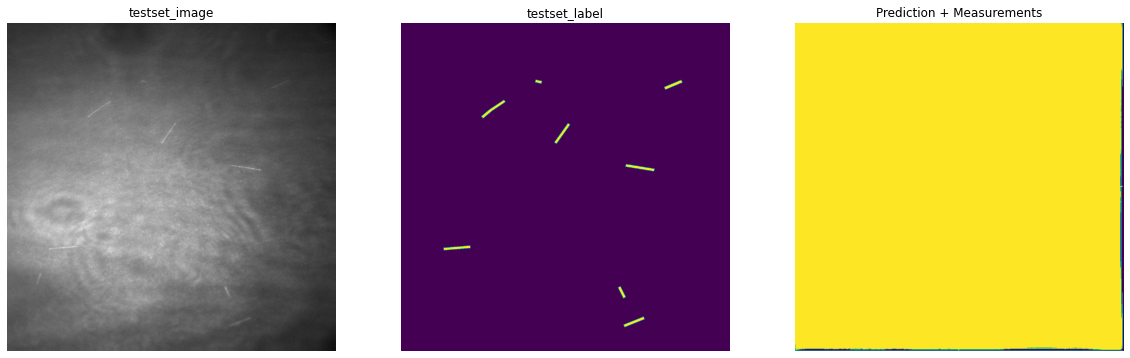

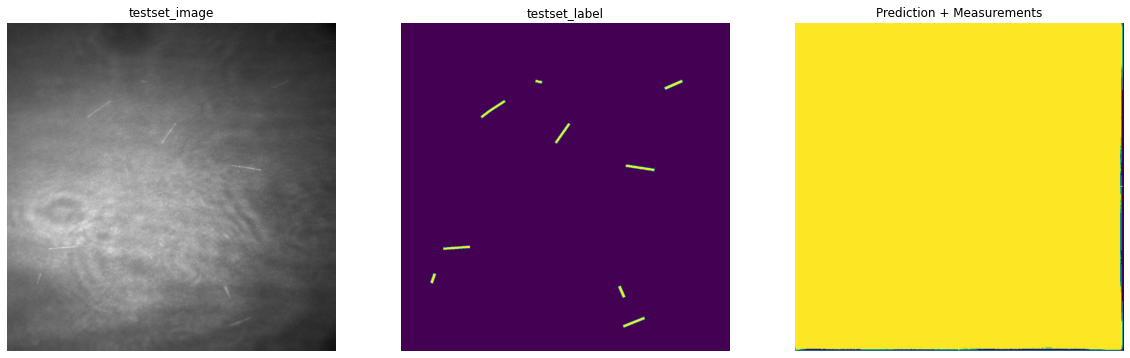

In [28]:
#Measure the lengths of Microtubules in testset

count = 1

for image in predict_score_images:

	#image = np.array(image, dtype=np.uint8)
	#Connect separate parts
	#dilataion = cv2.dilate(image, None, iterations=1)
	#erosion = cv2.erode(dilataion, None, iterations=1)

	label_original = score_masks[count-1]
	testset_original = score_images[count-1]

	#gray = cv2.cvtColor(erosion,cv2.COLOR_BGR2GRAY)
	# threshold
	#thresh = cv2.threshold(image,128,255,cv2.THRESH_BINARY)[1]

	# convert to binary by thresholding
	ret, binary_map = cv2.threshold(image,127,255,0)

	#binary_map = cv2.normalize(binary_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

	# do connected components processing
	nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_map, None, None, None, 8, cv2.CV_32S)

	#get CC_STAT_AREA component as stats[label, COLUMN] 
	areas = stats[1:,cv2.CC_STAT_AREA]

	image_noise_reduce = np.zeros((labels.shape), np.uint8)

	for i in range(0, nlabels - 1):
		if areas[i] >= 80:   #keep
			image_noise_reduce[labels == i + 1] = 255

	#image_noise_reduce_copy = image_noise_reduce.copy()
	# get contours
	cnts = cv2.findContours(image_noise_reduce, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)

	pixelsPerMetric = None

	# center point
	def midpoint(ptA, ptB):
		return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

	boxes = []
	tltrX_list = []
	tltrY_list = []
	blbrX_list = []
	blbrY_list = []

	tlblX_list = []
	tlblY_list = []
	trbrX_list = []
	trbrY_list = []

	dA_list = []
	dB_list = []

	# for loop for all contour
	for c in cnts:
		# if it's too small, it might be noise, just ignore it
		if cv2.contourArea(c) < 20:
			continue

		orig = image.copy()
		box = cv2.minAreaRect(c)
		box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
		box = np.array(box, dtype="int")
		
		box = perspective.order_points(box)

		boxes.append(box.astype("int"))

		#cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

		#for (x, y) in box:
			#cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

		(tl, tr, br, bl) = box
		(tltrX, tltrY) = midpoint(tl, tr)
		(blbrX, blbrY) = midpoint(bl, br)

		(tlblX, tlblY) = midpoint(tl, bl)
		(trbrX, trbrY) = midpoint(tr, br)

		tltrX_list.append(tltrX)
		tltrY_list.append(tltrY)
		blbrX_list.append(blbrX)
		blbrY_list.append(blbrY)

		tlblX_list.append(tlblX)
		tlblY_list.append(tlblY)
		trbrX_list.append(trbrX)
		trbrY_list.append(trbrY)


		#cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
		#cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
		#cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
		#cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

		#cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 0, 255), 2)
		#cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 0, 255), 2)

		dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
		dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

		dA_list.append(dA)
		dB_list.append(dB)

		#if pixelsPerMetric is None:
		#	pixelsPerMetric = dB / imgsize[1]

		#dimA = dA / pixelsPerMetric
		#dimB = dB / pixelsPerMetric

		#cv2.putText(orig, "{:.1f}".format(dA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
		#cv2.putText(orig, "{:.1f}".format(dB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,0.65, (255, 255, 255), 2)

		#cv2.imshow("Image", orig)
		#cv2.waitKey(0)

	tltrX_list = np.array(tltrX_list)
	tltrY_list = np.array(tltrY_list)
	blbrX_list = np.array(blbrX_list)
	blbrY_list = np.array(blbrY_list)

	tlblX_list = np.array(tlblX_list)
	tlblY_list = np.array(tlblY_list)
	trbrX_list = np.array(trbrX_list)
	trbrY_list = np.array(trbrY_list)

	dA_list = np.array(dA_list)
	#print(dA_list,dB_list)

	cnts_number = len(dA_list)
	print('The predicted image %s of testset detects Microtubules: %d' %(count, cnts_number))

	img = image_noise_reduce.copy()
	for i in range(len(tltrX_list)):
		cv2.line(img, (int(tltrX_list[i]), int(tltrY_list[i])), (int(blbrX_list[i]), int(blbrY_list[i])),(255, 0, 255), 2)
		cv2.line(img, (int(tlblX_list[i]), int(tlblY_list[i])), (int(trbrX_list[i]), int(trbrY_list[i])),(255, 0, 255), 2)
		cv2.putText(img, "{:.1f}".format(dA_list[i]), (int(tltrX_list[i] - 15), int(tltrY_list[i] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
		cv2.putText(img, "{:.1f}".format(dB_list[i]), (int(trbrX_list[i] + 10), int(trbrY_list[i])), cv2.FONT_HERSHEY_SIMPLEX,0.65, (255, 255, 255), 2)

	#img_box = image.copy()
	#for k in range(len(boxes)):
	#	cv2.drawContours(img_box, [boxes[k].astype("int")], -1, (0, 255, 0), 2)
	
	#cv2.imshow("Image_box", img_box)

	fig, ax = plt.subplots(ncols=3, figsize=(20, 8))
	ax[0].imshow(testset_original)
	ax[0].set_title('testset_image')
	ax[0].axis('off')
	
	ax[1].imshow(label_original)
	ax[1].set_title('testset_label')
	ax[1].axis('off')

	ax[2].imshow(img)
	ax[2].set_title('Prediction + Measurements')
	ax[2].axis('off')
	#cv2.imshow("Prediction + Measurement", img)

	#cv2.waitKey(0)
	count = count + 1